# Определение возраста  покупателей

Требуется построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


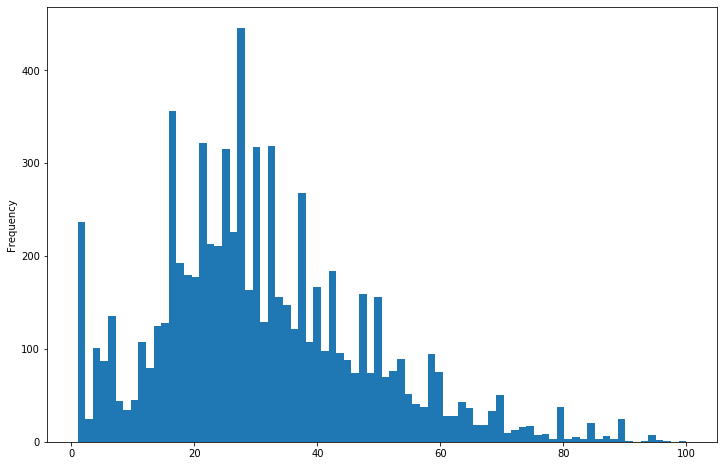

In [5]:
labels['real_age'].plot(kind='hist', figsize=(12,8), bins=80)  # добавил параметр bins

По графику - видна небольшая бимодальность. Скорее всего, как минимум, замешана ещё одна выборка в данных. Т.е. есть некий признак, который делает гарфик двугорбым. Большое количество младенцев, мало пожилых,однако есть и столетние.

In [6]:
features, target = next(train_gen_flow)

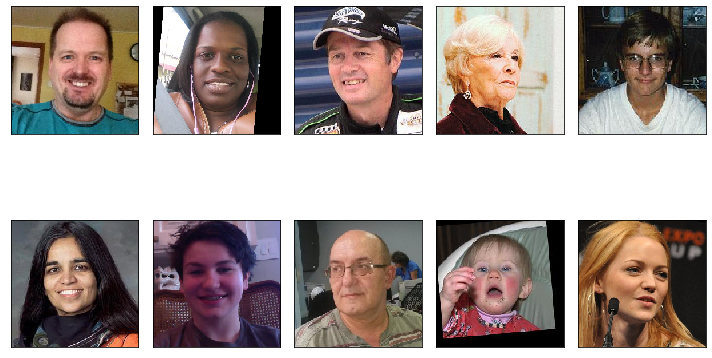

In [8]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Количество выборки возможно достаточное, чтобы не замораживать обучение предобученной модели ResNet.

1) В датасете есть старые и черно-белые фотографии. Имеет смысл делать аугментацию с тем, чтобы делать фотографию черно-белой в некотором проценте случаев. Возможно, стоит подкрутить цветовые каналы или яркость<br>

2) В датасете есть фотогарафии, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл делать аугментацию с rotation_range равным +-15-20 градусов в некотором проценте случаев. Поворачивать можно как само изображение так и объект отдельно от фона<br>

3) В датасете есть фотогарафии, на которых лица изображены в полупрофиль. Имеет смысл делать аугментацию с отражением по горизонтали в некотором проценте случаев<br>

4) В датасете есть фотогарафии с разным разрешением. Имеет смысл делать аугментацию с изменением контрастности изображения в некотором проценте случаев<br>

5) В датасете есть фотогарафии, на которых изображены не лица, а голова и часть туловища (иногда человек послностью). Имеет смысл делать аугментацию с обрезкой и масштабированием изображения в некотором проценте случаев, чтобы на фото были только лица примерно одного масштаба<br>

# 2. Обучение модели

Код запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.,
                                  horizontal_flip=True, vertical_flip=True,
                                  width_shift_range=0.2, height_shift_range=0.2)
    
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, 
                                                       directory='/datasets/faces/final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       subset='training', 
                                                       seed=12345)
    return train_gen_flow



def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.,
                                  horizontal_flip=True, vertical_flip=True,
                                  width_shift_range=0.2, height_shift_range=0.2)
    
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels, 
                                                       directory='/datasets/faces/final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       subset='validation', 
                                                       seed=12345)
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 115s - loss: 271.2820 - mae: 12.1161 - val_loss: 775.7975 - val_mae: 22.9351
Epoch 2/10
178/178 - 114s - loss: 113.1786 - mae: 8.0523 - val_loss: 765.7493 - val_mae: 22.5578
Epoch 3/10
178/178 - 107s - loss: 95.3142 - mae: 7.3644 - val_loss: 288.4612 - val_mae: 12.7309
Epoch 4/10
178/178 - 107s - loss: 83.3903 - mae: 6.9686 - val_loss: 136.3577 - val_mae: 8.9056
Epoch 5/10
178/178 - 106s - loss: 72.2103 - mae: 6.4623 - val_loss: 121.2814 - val_mae: 8.1900
Epoch 6/10
178/178 - 106s - loss: 65.1377 - mae: 6.1614 - val_loss: 139.3908 - val_mae: 8.8316
Epoch 7/10
178/178 - 106s - loss: 60.4521 - mae: 5.9397 - val_loss: 102.5345 - val_mae: 7.4303
Epoch 8/10
178/178 - 107s - loss: 52.9909 - mae: 5.5511 - val_loss: 84.0982 - val_mae: 7.0129
Epoch 9/10
178/178 - 107s - loss: 50.2413 - mae: 5.4493 - val_loss: 96.6678 - val_mae: 7.6458
Epoch 10/10
178/178 - 106s - loss: 46.9581 - mae: 5.2609 - val_loss: 81.9149 - val_mae: 6.7055

60/60 - 27s - loss: 81.8028 - mae: 6.6819
Test MAE: 6.6819

```

# 3. Анализ обученной модели

Модель справилась с поставленной задачей. MAE на тестовой выборке равно 6.68. Если увеличить количество эпох, накрутить к архитектуре еще доп. слои, исследовать их конфигурации и поиграть с другими параметрами, то можно получить меньшее значение метрики MAE. Это требует больших затрат ресурсов технических и времени.